# `Trotter Costs`

(off the top of my head so probably errors, sketchy things are mostly highlighted with ??.

We want to estimate the cost of implementing time evolution of a wavefunction:

$$
|\psi(t)\rangle = e^{-i H t}|\psi(0)\rangle
$$

fault tolerantly using qualtran. The time evolution unitary can be implemented using Suzuki-Trotter methods, that is, if

$$
H = H_1 + H_2,
$$
then we can always write
$$
e^{-i H t} = \lim_{n\rightarrow\infty} \left(e^{-iH_1 t/m} e^{-iH_2 t/m}\right)^{m}
$$
This allows us to approximate the unitary as
$$
e^{-i H t} = \prod_m^{N_t} e^{-iH_1 t/N_t} e^{-iH_2 t/N_t} + \mathcal{O}(\delta t^2) =  \prod_m^{N_t} e^{-iH_1 \delta t} e^{-iH_2 \delta t} + \mathcal{O}(\delta t^2)
$$
where we have $\delta_t = t / (N_t + 1)$. More sophisticated trotter breakups lead to better accuracy, at the cost of more complicated product formula.

For the ab-initio chemistry Hamiltonian in first quantization we have

\begin{align}
H &= -\frac{1}{2} \sum_i \nabla_i^2 -\sum_{i}\sum_{J} \frac{\zeta_J}{|R_J-r_i|} + \sum_{i < j} \frac{1}{|r_i-r_j|} \\
  &= T + U + V
\end{align}

Note that the Coulomb terms are diagonal in the position basis while the kinetic term is diagonal in the momentum basis. Thus we can employ a QFT: 
$$
|\psi(t)\rangle \approx \mathrm{QFT} e^{-i\delta t T} \mathrm{QFT}^{\dagger} e^{-i\delta t U}  e^{-i \delta t V} |\psi(0)\rangle
$$
so that all the terms can be implemented via a gate which implements something of the form $e^{-i \delta t \phi({r_i}) }$ via a phasing gate.

Specifically, we are concerned with implementing time evolution in the first quantized representation using a grid based approach. Our wavefunction will be represented on a real space grid 

$$
|\psi\rangle = \sum_{r_1\cdots r_\eta} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle
$$

and $r$ lives on a grid of size $N = (2 N_g + 1)^3$ if $N_g$ is the number of grid points in each spatial dimension. Thus we have $\eta$ registers of size $\log N$.

According to Jones et al., the main steps to implement are (for the electron-electron interaction $V$, but the other terms are similar)

\begin{align}
&\sum_{r_1\cdots r_\eta} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle \\
  &\rightarrow  \sum_{r_1\cdots r_\eta} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle|V(r_1\cdots r_\eta)\rangle \hspace{10em} \text{Compute pairwise potential in ancilla registers} \\
  &\rightarrow \sum_{r_1\cdots r_\eta} e^{-i V(r_1\cdots r_\eta)} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle|V(r_1\cdots r_\eta)\rangle \hspace{5.5em} \text{Phase the state with computed potential} \\ 
  &\rightarrow \sum_{r_1\cdots r_\eta} e^{-i V(r_1\cdots r_\eta)} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle|0\cdots0\rangle \hspace{7.8em} \text{Uncompute potential in ancilla register} \\ 
\end{align}
in the above the ancilla register storing the value of the potential is of size.

To compute the potential we need to compute $\frac{1}{r_{ij}}$ which can be done in two steps: 1) compute $|r_{ij}^2\rangle = |(x_i - x_j)^2 + (y_i-y_j)^2 + (z_i - z_j)^2\rangle$ into a register of size $2 \log N$ (??, assuming any grid spacing prefactors are accounted for elsewhere), and 2) compute the inverse square root of the number in this register ($r_{ij}$). The cost of computing the sum of squares of the electronic positions requires computing the 3 subtractions and the sum of 3 squares which has a cost of $3n^2 - n - 1$ Toffolis.

To compute $\frac{1}{r_{ij}}$ we write solve $x^{-2} = r_{ij}^2$ which has solution $x^* = \frac{1}{r_{ij}}$. This can be solved iteratively using the Newton-Raphson method: 

\begin{align}
a_{n+1} &= a_{n} - \frac{a_n^3(1-r_{ij}^2 a_n^2)}{-2 a_n^2} \\
        &= \frac{1}{2}a_n\left(3-a_n^2 r_{ij}^2\right).
\end{align}

In the fusion paper this method is improved upon by using a hybrid approach based upon QROM function interpolation in conjunction with this Newton-Raphson iteration. A further optimization is introduced to include the scaling factors necessary for the potential directly in the Newton-Raphson step (i.e. all the timestep and factor of two factors.)

The basic idea is to first fit a cubic polynomial to $\frac{1}{r_{ij}}$ in a piecewise fashion over an interval of size 1. We can obtain the function at points outside the interval by appropriately scaling the polynomial coefficients by a power of 2. We can then use our variably spaced QROM to output the appropriately scaled polynomial coefficients within the desired range we want to evaluate our function at, after which we can evaluate the polynomial using simple arithmetic.  

As an example consider approximating $\frac{1}{\sqrt{x}}$ in the range [1, 3/2]. The fusion paper provides the following approximation

$$
\frac{1}{\sqrt{x}} \approx a_0 - a_1 (x-1) + a_2 (x-1)^2 - a_3 (x-1)^3
$$

let's see how this compares: 

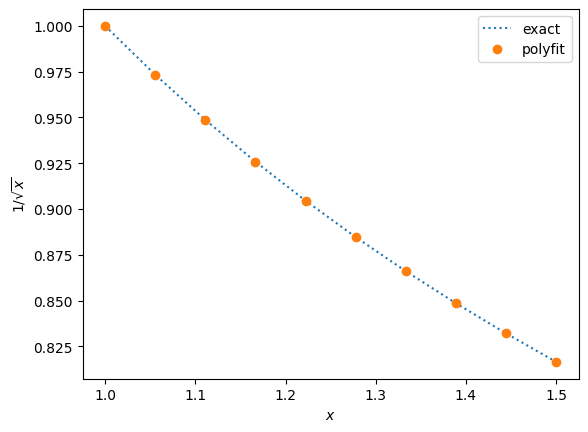

max error = 5.8675108801198306e-05


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def polynomial_approx_range_one(x: float):
    a0 = 0.99994132489119882162
    a1 = 0.49609891915903542303
    a2 = 0.33261112772430493331
    a3 = 0.14876762006038398086
    return a0 - (x-1) * (a1 - (x-1) * (a2 - a3*(x-1)))


xs = np.linspace(1, 1.5, 10)
plt.plot(xs, 1.0 / xs**0.5, ls=":", label="exact")
plt.plot(xs, polynomial_approx_range_one(xs), marker='o', label="polyfit", lw=0)
plt.xlabel("$x$")
plt.ylabel("$1/\sqrt{x}$")
plt.legend()
plt.show()
delta = np.max(np.abs(polynomial_approx_range_one(xs) - xs**(-0.5)))
print(f"max error = {delta}")

Ok, that's pretty good, but the author's of the fusion paper now combine this with a step of Newton-Raphson to improve the accuracy. Let's see if that's the case:

In [43]:
def newton_raphson_step(x, y0):
    delta = 5.1642030908180720584e-9
    yprime = 0.5 * y0 * (3 + delta - y0**2 * x) 
    return yprime

poly_fit = polynomial_approx_range_one(xs)
newton_update = newton_raphson_step(xs, poly_fit)
delta = np.max(np.abs(newton_update - xs**(-0.5)))
print(f"max error after Newton-Raphson = {delta}")

max error after Newton-Raphson = 2.5821014215665627e-09


Perf! Now how do we obtain the value of the function in say the range [16, 23], well this is just $16 = 2^4$ times the range of [1, 3/2], thus we can appropriately scale our polynomial coefficients by a factor of $2^4$. Let's check this:

In [44]:
def polynomial_approx_range_one_scaling(x: float, scale_power: int):
    a0 = 0.99994132489119882162 / 2**(scale_power/2.0)
    a1 = 0.49609891915903542303 / 2**(3*scale_power/2.0)
    a2 = 0.33261112772430493331 / 2**(5*scale_power/2.0)
    a3 = 0.14876762006038398086 / 2**(7*scale_power/2.0)
    return a0 - (x-2**scale_power) * (a1 - (x-2**scale_power) * (a2 - a3*(x-2**scale_power)))

xs_new = 2**4 * xs
poly_fit = polynomial_approx_range_one_scaling(xs_new, scale_power=4)
newton_update = newton_raphson_step(xs_new, poly_fit)
delta = np.max(np.abs(newton_update - xs_new**(-0.5)))
print(f"max error after Newton-Raphson = {delta}")

max error after Newton-Raphson = 6.455253553916407e-10


Thus, we can use QROM to output the appropriately scaled polynomial coefficients in our desired range $[2^m, 2^m 3/2]$, followed by three multiplications at a cost of roughly 3$n^2$, Toffolis. 

# Kinetic Energy Bloq
Recall that for a grid based Hamiltonian we represent our state on a real space grid of size $N$ where $x,y,z \in [-(N^{1/3}-1)/2, (N^{1/3}-1)/2]$. 

In [45]:
for n in range(3, 21): 
    num_grid_total = (2*n+1)**3
    num_grid_each_dim = int((np.ceil(num_grid_total**(1/3)) - 1)//2)
    num_bits_each_dim = int(np.ceil(np.log2(np.ceil(num_grid_total**(1/3.0))))) + 1 
    assert num_bits_each_dim == (2*n + 1 - 1).bit_length() + 1

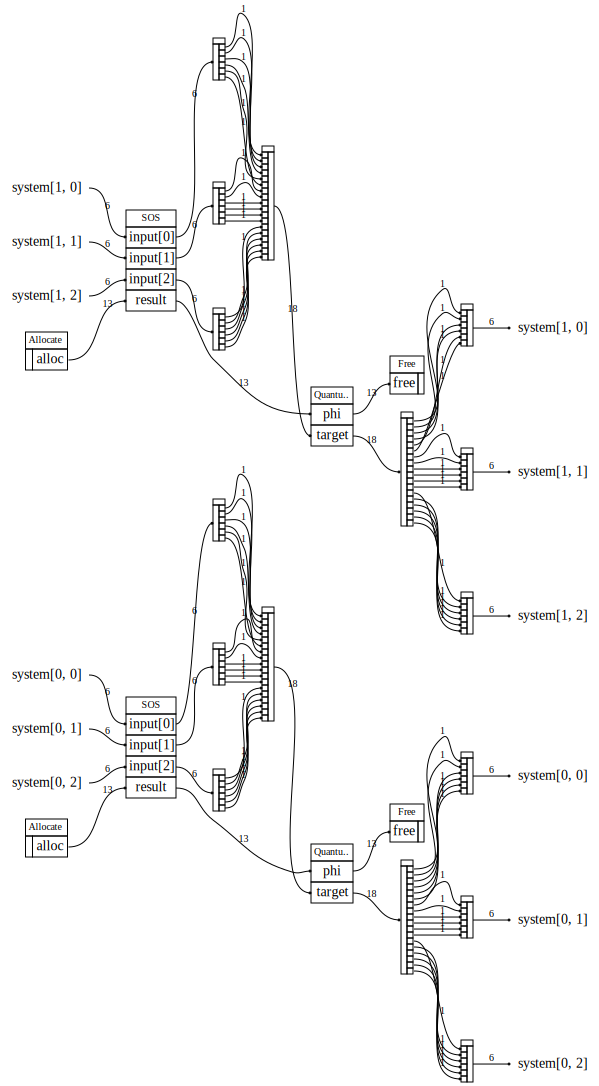

In [52]:
from qualtran.bloqs.chemistry.trotter import KineticEnergy 
from qualtran.drawing import show_bloq
num_elec = 2
num_grid_each_dim = 2*10 + 1
ke_bloq = KineticEnergy(num_elec, num_grid_each_dim)
cbloq = ke_bloq.decompose_bloq()
show_bloq(ke_bloq.decompose_bloq())


# Potential Energy Bloq



In [97]:

from qualtran.bloqs.chemistry.trotter import PotentialEnergy 
from qualtran.drawing import show_bloq
num_elec = 3
num_grid_each_dim = 2*10 + 1
ke_bloq = PotentialEnergy(num_elec, num_grid_each_dim)
cbloq = ke_bloq.decompose_bloq()
show_bloq(ke_bloq.decompose_bloq())

ValueError: `free` expects a single Soquet to free.